In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## <step1. 크롤링>: 크롤링으로 웹 데이터 가져오기
### [BeautifulSoup을 이용한 웹 크롤링]

**페이지리스트가져오기**

In [32]:
import requests
from bs4 import BeautifulSoup
import re

# 크롤링할 사이트 주소를 정의합니다. 
source_url = 'https://namu.wiki/RecentChanges'

# 사이트의 html 구조에 기반하여 크롤링을 수행합니다. 
req = requests.get(source_url)
html = req.content
soup = BeautifulSoup(html,'lxml')
contents_table = soup.find(name='table')
table_body = contents_table.find(name='tbody')
table_rows = table_body.find_all(name='tr')

In [33]:
# a태그의 href 속성을 리스트로 추출하여, 크롤링 할 페이지 리스트를 생성합니다. 
page_url_base = 'https://namu.wiki'
page_urls = []
for index in range(0, len(table_rows)):
    first_td = table_rows[index].find_all('td')[0]
    td_url = first_td.find_all('a')
    if len(td_url) >0:
        page_url = page_url_base + td_url[0].get('href')
        if 'png' not in page_url:
            page_urls.append(page_url)
            
# 중복 url을 제거합니다.
page_urls = list(set(page_urls))
for page in page_urls[:5]:
    print(page)

https://namu.wiki/w/1%EB%B0%95%202%EC%9D%BC/%EC%82%AC%EA%B1%B4%EC%82%AC%EA%B3%A0/4%EA%B8%B0
https://namu.wiki/w/%ED%9E%88%EB%A1%9C%EB%A7%88%EC%B9%98%20%EB%82%98%EB%82%98%EB%AF%B8
https://namu.wiki/w/CT66%20%EB%9E%A8%ED%8C%8C%ED%8A%B8
https://namu.wiki/w/%EA%B3%A0%EB%87%8C(%EC%9D%B8%ED%84%B0%EB%84%B7%20%EB%B0%A9%EC%86%A1%EC%9D%B8)
https://namu.wiki/w/%EC%A3%BD%EC%A7%80%20%EC%95%8A%EB%8A%94%20%EC%97%91%EC%8A%A4%ED%8A%B8%EB%9D%BC


**페이지 내 텍스트 구조 확인**

In [34]:
req = requests.get(page_urls[0])
html = req.content
soup = BeautifulSoup(html, 'lxml')
contents_table = soup.find(name='article')
title = contents_table.find_all('h1')[0]
category = contents_table.find_all('ul')[0]
contents_paragraphs = contents_table.find_all(name='div', attrs={'class':'wiki-paragraph'})
content_corpus_list = []

for paragraphs in contents_paragraphs:
    content_corpus_list.append(paragraphs.text)
contents_corpus = ''.join(content_corpus_list)

print(title.text)
print('\n')
print(category.text)
print('\n')
print(contents_corpus)

1박 2일/사건사고/4기 


방송 사건사고1박 2일


   상위 문서: 1박 2일/사건사고1. 천안함 10주기 추모 모자 모자이크 처리 논란2020년 7월 12일 방송에서 라비가 착용하고 나온 천안함 10주기 추모 모자를 모자이크 처리한것이 알려지면서 논란이 되었다. 보통 특정 상표가 있는 의류등을 착용하면 그 상표에 모자이크를 삽입하는 경우는 해당 프로그램과 무관한 간접광고일 때가 대부분이다. 그러나 라비는 2020년 5월 31일 방송에서도 해당 모자를 하얀색 버전으로 착용하고 등장했었는데 이때는 제작진은 모자이크 처리를 하지 않았다. 이러면서 의문이 커졌는데, 이후 1박2일 시즌 4 제작진측에서 공식입장을 냈는데, "특별히 브랜드 상표 노출을 조심하라는 내부 방침이 있어서 일괄적으로 블러 작업을 의뢰했다"며 "최종 작업을 하는 과정에서 작업자가 브랜드 로고인줄 알고 블러처리를 했다"고 해명했고 앞으로는 작은부분이라도 더 신경써서 오해의 소지가 없도록 방송하겠다고 밝혔다. 이 문서의 내용 중 전체 또는 일부는 1박 2일/사건사고 문서의 r552 판, 번 문단에서 가져왔습니다. 이전 역사 보러 가기 이 문서의 내용 중 전체 또는 일부는 다른 문서에서 가져왔습니다. [ 펼치기 · 접기 ]1박 2일/사건사고 문서의 r552 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사) 문서의 r 판, 번 문단 (이전 역사)


### [나무위키 최근변경 테이터 크롤링]

In [36]:
# 크롤링한 데이터를 데이터 프레임으로 만들기 위해 준비합니다.
columns = ['title', 'category', 'content_text']
df = pd.DataFrame(columns=columns)

# 각 페이지별 '제목', '카테고리', '본문' 정보를 데이터 프레임으로 만듭니다.
for page_url in page_urls:

    # 사이트의 html 구조에 기반하여 크롤링을 수행합니다.
    req = requests.get(page_url)
    html = req.content
    soup = BeautifulSoup(html, 'lxml')
    contents_table = soup.find(name="article")
    title = contents_table.find_all('h1')[0]
    category = contents_table.find_all('ul')[0]
    content_paragraphs = contents_table.find_all(name="div", attrs={"class":"wiki-paragraph"})
    content_corpus_list = []
    
    # 페이지 내 제목 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if title is not None:
        row_title = title.text.replace("\n", " ")
    else:
        row_title = ""
    
    # 페이지 내 본문 정보에서 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if content_paragraphs is not None:
        for paragraphs in content_paragraphs:
            if paragraphs is not None:
                content_corpus_list.append(paragraphs.text.replace("\n", " "))
            else:
                content_corpus_list.append("")
    else:
        content_corpus_list.append("")
        
    # 페이지 내 카테고리정보에서 “분류”라는 단어와 개행 문자를 제거한 뒤 추출합니다. 만약 없는 경우, 빈 문자열로 대체합니다.
    if category is not None:
        row_category = category.text.replace("\n", " ")
    else:
        row_category = ""
    
    # 모든 정보를 하나의 데이터 프레임에 저장합니다.
    row = [row_title, row_category, "".join(content_corpus_list)]
    series = pd.Series(row, index=df.columns)
    df = df.append(series, ignore_index=True)

IndexError: list index out of range

In [37]:
df.head(5)

,title,category,content_text
0,1박 2일/사건사고/4기,방송 사건사고1박 2일,상위 문서: 1박 2일/사건사고1. 천안함 10주기 추모 모자 모자이크 처리 ...
1,히로마치 나나미,BanG Dream!/등장인물베이시스트 캐릭터나무위키 뱅드림 프로젝트,차세대 걸즈 밴드 프로젝트BanG Dream! [ 밴드 목록 열기 · 닫기 ]밴드우...
2,CT66 램파트,라스트오리진/전투원,AGSCT66 램파트CT66 Rampart번호114 등급 부대 시티 가드 기업펙스 ...
3,고뇌(인터넷 방송인),대한민국의 남성 인터넷 방송인/ㄱ유튜버/ㄱ트위치 스트리머/ㄱ나무위키 인터넷 방송인 ...,고뇌이메일chic891@naver.com관련 링크 1. 개요2. 상세2.1. 소개...
4,죽지 않는 엑스트라,웹소설/ㅈ빙의물카카오페이지/소설한국 판타지 소설게임을 소재로 한 작품,"죽지 않는 엑스트라NEVERDIE EXTRA장르퓨전 판타지, 게임빙의작가토이카출판사..."


## <step2.추출> :키워드추출
### [텍스트 데이터 전처리]

**텍스트 정제 함수: 한글 이외의 문자는 전부 제거 합니다.**

In [38]:
def text_cleaning(text):
    hangul = re.compile('[^ ㄱ - 가-힣]+') #한글의 정규표현식을 나타냅니다. 
    result = hangul.sub('',text)
    return result

In [39]:
print(text_cleaning(df['content_text'][0]))

  상위 문서 박 일사건사고 천안함 주기 추모 모자 모자이크 처리 논란년 월 일 방송에서 라비가 착용하고 나온 천안함 주기 추모 모자를 모자이크 처리한것이 알려지면서 논란이 되었다 보통 특정 상표가 있는 의류등을 착용하면 그 상표에 모자이크를 삽입하는 경우는 해당 프로그램과 무관한 간접광고일 때가 대부분이다 그러나 라비는 년 월 일 방송에서도 해당 모자를 하얀색 버전으로 착용하고 등장했었는데 이때는 제작진은 모자이크 처리를 하지 않았다 이러면서 의문이 커졌는데 이후 박일 시즌  제작진측에서 공식입장을 냈는데 특별히 브랜드 상표 노출을 조심하라는 내부 방침이 있어서 일괄적으로 블러 작업을 의뢰했다며 최종 작업을 하는 과정에서 작업자가 브랜드 로고인줄 알고 블러처리를 했다고 해명했고 앞으로는 작은부분이라도 더 신경써서 오해의 소지가 없도록 방송하겠다고 밝혔다 이 문서의 내용 중 전체 또는 일부는 박 일사건사고 문서의  판 번 문단에서 가져왔습니다 이전 역사 보러 가기 이 문서의 내용 중 전체 또는 일부는 다른 문서에서 가져왔습니다  펼치기  접기 박 일사건사고 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사 문서의  판 번 문단 이전 역사


**각 피처마다 데이터 전처리를 적용합니다.**

In [40]:
df['title'] = df['title'].apply(lambda x:text_cleaning(x))
df['category'] = df['category'].apply(lambda x:text_cleaning(x))
df['content_text'] = df['content_text'].apply(lambda x:text_cleaning(x))

In [41]:
df.head(5)

,title,category,content_text
0,박 일사건사고기,방송 사건사고박 일,상위 문서 박 일사건사고 천안함 주기 추모 모자 모자이크 처리 논란년 월 일 방...
1,히로마치 나나미,등장인물베이시스트 캐릭터나무위키 뱅드림 프로젝트,차세대 걸즈 밴드 프로젝트 밴드 목록 열기 닫기 밴드우시고메 리미야마부키 사아...
2,램파트,라스트오리진전투원,램파트 번호 등급 부대 시티 가드 기업펙스 콘소시엄타입 경장형제조사오메가 산업역할...
3,고뇌인터넷 방송인,대한민국의 남성 인터넷 방송인ㄱ유튜버ㄱ트위치 스트리머ㄱ나무위키 인터넷 방송인 프로젝트,고뇌이메일관련 링크 개요 상세 소개한 뉴메타 목록 닷지유도 논란 기타리그 오브 ...
4,죽지 않는 엑스트라,웹소설빙의물카카오페이지소설한국 판타지 소설게임을 소재로 한 작품,죽지 않는 엑스트라 장르퓨전 판타지 게임빙의작가토이카출판사인타임연재처카카오페이지 연...


### [말뭉치 만들기]

**각 피터마다 말뭉치를 생성합니다.**

In [42]:
title_corpus = ''.join(df['title'].tolist())
category_corpus = ''.join(df['category'].tolist())
content_corpus = ''.join(df['content_text'].tolist())
print(title_corpus)

박 일사건사고기 히로마치 나나미  램파트 고뇌인터넷 방송인 죽지 않는 엑스트라   오늘도 우라라 원시 헌팅 라이프 창조신 카봇 호크 셀리미예 모스크 노르위전 에어 셔틀 스터디그룹웹툰등장인물 히트맨  캐빈 인 더 우즈 노르웨이의 숲소설 취한무드등 


### [konlpy를 이용한 키워드 추출]

- 오류 참고: http://blog.naver.com/PostView.nhn?blogId=shino1025&logNo=221589430674&categoryNo=0&parentCategoryNo=0&viewDate=&currentPage=1&postListTopCurrentPage=1&from=postView
- https://github.com/hexists/test_konlpy/issues/1
* java 이클립스에서 heapsize 늘리라는 오류 발생 (늘리면 됨)

In [43]:
from konlpy.tag import Okt
from collections import Counter

In [44]:
# konlpy의 형태소 분석기로 명사 단위의 키워드를 추출합니다.
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(content_corpus)
count = Counter(nouns)

In [45]:
count

Counter({'상위': 6,
         '문서': 75,
         '박': 4,
         '사건': 17,
         '사고': 5,
         '천안함': 2,
         '주기': 4,
         '추모': 2,
         '모자': 3,
         '모자이크': 4,
         '처리': 8,
         '논란': 7,
         '년': 76,
         '월': 53,
         '일': 54,
         '방송': 26,
         '라비': 3,
         '착용': 3,
         '것': 193,
         '보통': 25,
         '특정': 3,
         '상표': 3,
         '의류': 1,
         '등': 90,
         '그': 153,
         '삽입': 2,
         '경우': 47,
         '해당': 13,
         '프로그램': 3,
         '무관': 1,
         '간접': 5,
         '광고': 5,
         '때': 79,
         '대부분': 15,
         '하얀색': 1,
         '버전': 2,
         '등장': 81,
         '진': 7,
         '의문': 1,
         '이후': 61,
         '박일': 1,
         '시즌': 9,
         '공식': 3,
         '입장': 3,
         '브랜드': 3,
         '노출': 1,
         '조심': 2,
         '내부': 4,
         '방침': 1,
         '일괄': 1,
         '블러': 2,
         '작업': 4,
         '의뢰': 1,
         '최종': 3,
         '과

### [키워드 가다듬기]

**한글자 키워드 제거**

In [47]:
remove_char_counter = Counter({x:count[x] for x in count if len(x) >1})
print(remove_char_counter)

Counter({'등장': 81, '문서': 75, '때문': 74, '자신': 66, '던전': 66, '스킬': 65, '다른': 63, '이후': 61, '보스': 61, '거대': 59, '공격': 57, '문단': 55, '정도': 54, '윤가민': 54, '게임': 53, '와타나베': 52, '이전': 51, '승급': 48, '경우': 47, '역사': 47, '램파트': 47, '가지': 46, '카봇': 46, '처음': 45, '레벨': 45, '영화': 43, '하나': 42, '대륙': 42, '노르웨이': 42, '캐릭터': 40, '유저': 40, '히트': 40, '모습': 39, '여기': 36, '작품': 36, '이자': 36, '사실': 35, '호크': 35, '다화': 35, '위해': 34, '사람': 33, '가사': 33, '에이스': 33, '시작': 32, '등급': 32, '그룹': 32, '내용': 31, '생각': 31, '영상': 31, '보고': 30, '보호': 30, '그대': 30, '몬스터': 30, '체력': 29, '직업': 29, '인물': 28, '친구': 28, '또한': 28, '셰어': 28, '하루키': 28, '이상': 27, '가장': 27, '도시': 27, '이지우': 27, '방송': 26, '거의': 26, '기술': 26, '주인공': 26, '대한': 26, '적성': 26, '앨범': 26, '일본': 26, '보통': 25, '레이': 25, '본인': 25, '매우': 25, '유성': 25, '정규': 24, '소설': 24, '에반': 24, '백파': 24, '밴드': 23, '마치': 23, '파티': 23, '나미': 23, '존재': 23, '딜러': 23, '차단': 23, '공고': 23, '히로': 22, '언급': 22, '마음': 22, '부분': 22, '시간': 22, '사랑': 22, '좀비': 22, '강인': 22, '부족': 22,

**불용어 제거**
- 한국어 약식 불용어사전 예시 파일

In [48]:
korean_stopwords_path = './dataset/data/korean_stopwords.txt'

with open(korean_stopwords_path, encoding='utf-8') as f:
    stopwords = f.readlines()
stopwords = [x.strip() for x in stopwords]
print(stopwords[:10])

['아', '휴', '아이구', '아이쿠', '아이고', '어', '나', '우리', '저희', '따라']


**나무위키 페이지에 맞는 불용어를 추가합니다**

In [49]:
namu_wiki_stopwords = ['상위', '문서', '내용', '누설', '아래', '해당', '설명', '표기', '추가', '모든', '사용', '매우', '가장',
                       '줄거리', '요소', '상황', '편집', '틀', '경우', '때문', '모습', '정도', '이후', '사실', '생각', '인물', 
                       '이름', '년월']
for stopword in namu_wiki_stopwords:
    stopwords.append(stopword)

**키워드 데이터에서 불용어를 제거합니다**

In [52]:
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})
print(remove_char_counter)

Counter({'등장': 81, '던전': 66, '스킬': 65, '보스': 61, '거대': 59, '공격': 57, '문단': 55, '윤가민': 54, '게임': 53, '와타나베': 52, '이전': 51, '승급': 48, '역사': 47, '램파트': 47, '가지': 46, '카봇': 46, '처음': 45, '레벨': 45, '영화': 43, '대륙': 42, '노르웨이': 42, '캐릭터': 40, '유저': 40, '히트': 40, '작품': 36, '이자': 36, '호크': 35, '다화': 35, '위해': 34, '사람': 33, '가사': 33, '에이스': 33, '시작': 32, '등급': 32, '그룹': 32, '영상': 31, '보고': 30, '보호': 30, '그대': 30, '몬스터': 30, '체력': 29, '직업': 29, '친구': 28, '셰어': 28, '하루키': 28, '도시': 27, '이지우': 27, '방송': 26, '기술': 26, '주인공': 26, '대한': 26, '적성': 26, '앨범': 26, '일본': 26, '보통': 25, '레이': 25, '본인': 25, '유성': 25, '정규': 24, '소설': 24, '에반': 24, '백파': 24, '밴드': 23, '파티': 23, '나미': 23, '존재': 23, '딜러': 23, '차단': 23, '공고': 23, '히로': 22, '언급': 22, '마음': 22, '부분': 22, '사랑': 22, '좀비': 22, '강인': 22, '부족': 22, '데이나': 22, '멤버': 21, '세계': 21, '전투': 21, '사이': 21, '탱커': 21, '이야기': 21, '여자': 21, '신화': 21, '마티': 21, '다시': 20, '방어': 20, '수준': 20, '려욱': 20, '스톰': 20, '스터디': 20, '대학': 20, '학년': 19, '지금': 19, '아버지': 19, '그녀':

## <step3. 시각화>: 워드클라우드 시각화

In [66]:
import random
import pytagcloud
import webbrowser

**가장 출현 빈도수가 높은 40개의 단어를 선정합니다.**

In [67]:
ranked_tags = remove_char_counter.most_common(40)

**pytagcloud 로 출력할 40개의 단어를 입력합니다. 단어 출력의 퇴대 크기는 80으로 제한합니다.**

In [68]:
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)

**patycloud 이미지를 생성합니다. 폰트는 나눔 고딕을 사용합니다.**

In [74]:
pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900,600), fontname = 'NanumGothic', rectangular=False)

**생성한 이미지를 주피터 노트북에서 출력합니다.**

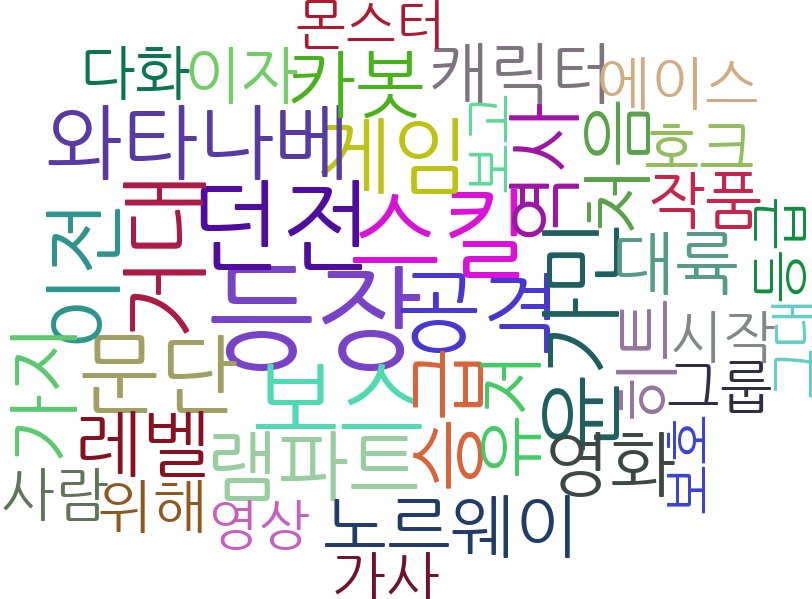

In [76]:
from IPython.display import Image
Image(filename='wordcloud.jpg')

### [나무위키 키워드 시각화]

**제목 키워드**

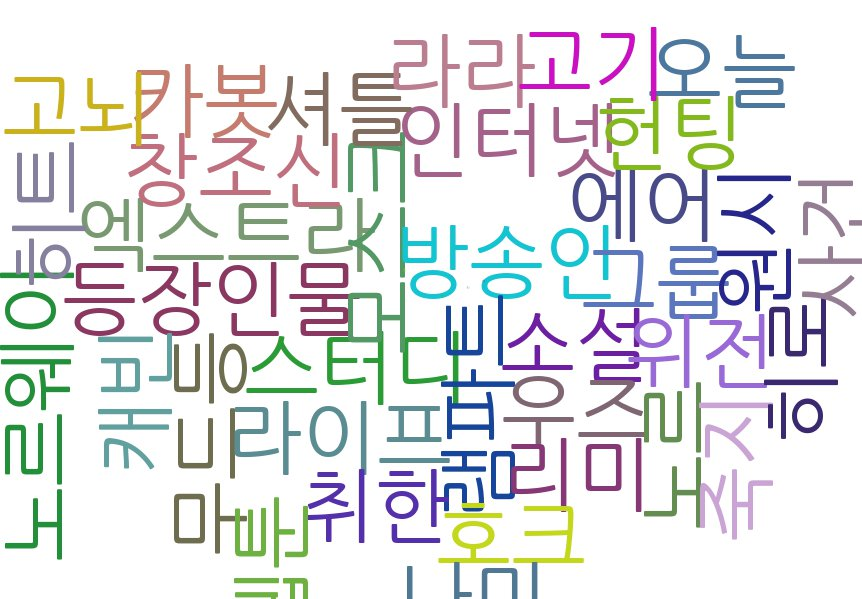

In [77]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(title_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x: count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x: remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'title_wordcloud.jpg', size=(900,600), fontname='NanumGothic', rectangular=False)

Image(filename='title_wordcloud.jpg')

**카테고리 키워드**

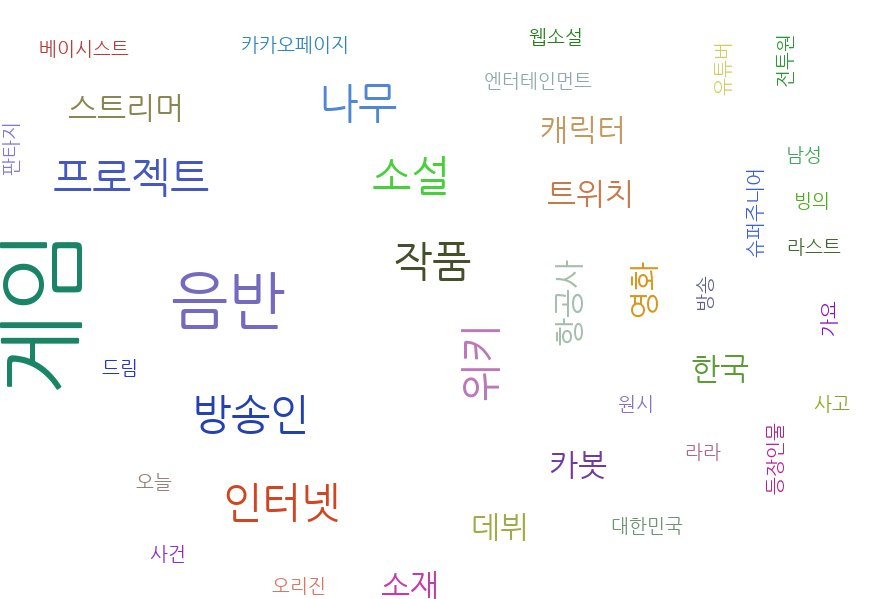

In [80]:
nouns_tagger = Okt()
nouns = nouns_tagger.nouns(category_corpus)
count = Counter(nouns)

remove_char_counter = Counter({x : count[x] for x in count if len(x) > 1})
remove_char_counter = Counter({x : remove_char_counter[x] for x in count if x not in stopwords})

ranked_tags = remove_char_counter.most_common(40)
taglist = pytagcloud.make_tags(ranked_tags, maxsize=80)
pytagcloud.create_tag_image(taglist, 'category_wordcloud.jpg', size=(900, 600), fontname='NanumGothic', rectangular=False)

Image(filename='category_wordcloud.jpg')